In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

- 图像超分辨

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

- 使用PETS数据集

In [3]:
path = untar_data(URLs.PETS)
path
path.ls()

PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet')

[PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/small-256'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/crappy'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/image_gen'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/models'),
 PosixPath('/home/lyc/.fastai/data/oxford-iiit-pet/small-96')]

In [4]:
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

- 生成低分辨率图片,通过resize

In [5]:
# il = ImageList.from_folder(path_hr)

In [6]:
# def resize_one(fn, i, path=None, size=None):
#     dest = path/fn.relative_to(path_hr)
#     dest.parent.mkdir(parents=True, exist_ok=True)
#     img = PIL.Image.open(fn)
#     targ_sz = resize_to(img, size, use_min=True)
#     img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
#     img.save(dest, quality=60)

In [7]:
doc(parallel)

parallel [source] [test] parallel ( func , arr : Collection , max_workers : int = None ) 
 
 × No tests found for parallel . To contribute a test please refer to this guide and this discussion . Call func on every element of arr in parallel using max_workers . 
 Show in docs

In [8]:
# sets = [(path_lr, 96), (path_mr, 256)]
# for p,size in sets:
#     if not p.exists(): 
#         print(f"resizing to {size} into {p}")
#         parallel(partial(resize_one, path=p, size=size), il.items)

- 训练数据

In [9]:
bs,size=32,128
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [10]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [11]:
data = get_data(bs,size)  # 高分辨率

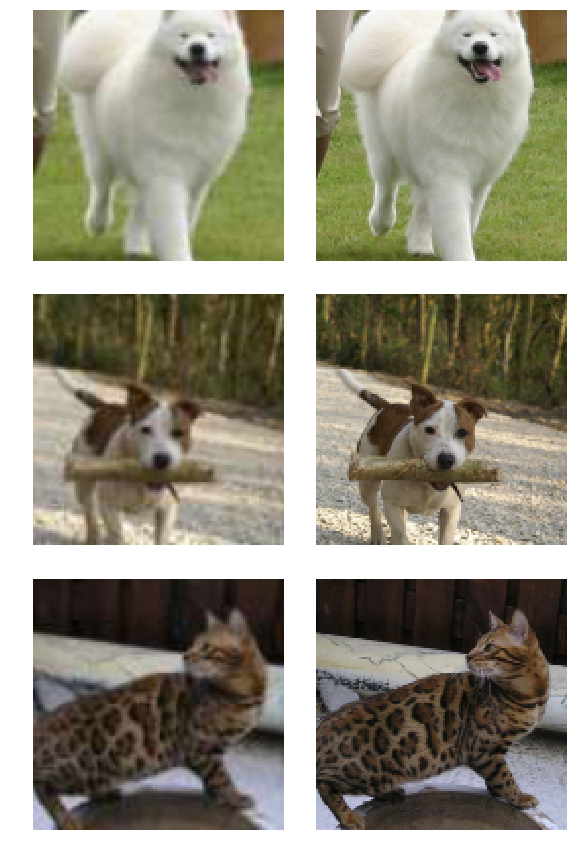

In [12]:
data.show_batch(ds_type=DatasetType.Valid, rows=3)

## Feature loss

In [13]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self):
        self.hooks.remove()

In [14]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])
t
t.shape

tensor([[[[0.5120, 0.5126, 0.5240,  ..., 0.4543, 0.4417, 0.4456],
          [0.5220, 0.5304, 0.5412,  ..., 0.4579, 0.4585, 0.4676],
          [0.5319, 0.5182, 0.5329,  ..., 0.4759, 0.4763, 0.4774],
          ...,
          [0.3254, 0.3101, 0.2959,  ..., 0.4628, 0.4719, 0.4812],
          [0.3375, 0.3430, 0.3187,  ..., 0.4589, 0.5317, 0.4772],
          [0.3570, 0.3571, 0.3342,  ..., 0.4450, 0.4681, 0.4762]],

         [[0.4833, 0.4794, 0.4897,  ..., 0.3540, 0.3494, 0.3534],
          [0.4710, 0.4804, 0.4938,  ..., 0.3678, 0.3683, 0.3774],
          [0.4926, 0.4789, 0.4907,  ..., 0.3838, 0.3857, 0.3871],
          ...,
          [0.3552, 0.3627, 0.3539,  ..., 0.5043, 0.5145, 0.5238],
          [0.3610, 0.3900, 0.3790,  ..., 0.5075, 0.5788, 0.5243],
          [0.3750, 0.3958, 0.3768,  ..., 0.5065, 0.5279, 0.5360]],

         [[0.4098, 0.4077, 0.4224,  ..., 0.2054, 0.1948, 0.1988],
          [0.4163, 0.4212, 0.4304,  ..., 0.1997, 0.2047, 0.2139],
          [0.4346, 0.4209, 0.4264,  ..., 0

torch.Size([2, 3, 128, 128])

In [15]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [16]:
y = gram_matrix(t)
y
y.shape

tensor([[[0.1348, 0.1364, 0.1133],
         [0.1364, 0.1386, 0.1142],
         [0.1133, 0.1142, 0.0990]],

        [[0.1348, 0.1364, 0.1133],
         [0.1364, 0.1386, 0.1142],
         [0.1133, 0.1142, 0.0990]]])

torch.Size([2, 3, 3])

In [17]:
base_loss = F.l1_loss

In [21]:
vgg_m = vgg16_bn(True).features.cuda().eval()

RuntimeError: storage has wrong size: expected 0 got 512

In [ ]:
requires_grad(vgg_m, False)

In [20]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks
[vgg_m[i] for i in blocks]

NameError: name 'vgg_m' is not defined

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

### 训练模型

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr=1e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [ ]:
do_fit('1a', slice(lr))

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('1b', slice(lr/2.6**3,lr/5))

- 变大图片

In [ ]:
data = get_data(12,size*2)

In [ ]:
learn.data = data
learn.freeze()
gc.collect()

In [ ]:
learn.load('1b');

In [ ]:
do_fit('2a'， slice(lr/2))

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('2b', slice(1e-6,lr/5), pct_start=0.3)

### 测试

In [ ]:
learn = None
gc.collect();

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 6000: size=(820, 1024) # >  8GB RAM
else:           size=( 480, 720) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

In [ ]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('2b');

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]
fn

In [ ]:
img = open_image(fn)
img.shape

In [ ]:
p,img_hr,b = learn.predict(img)

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
Image(img_hr).show(figsize=(18,15))